#Import library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import xgboost as xgb
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os


In [ ]:
path='/content/drive/MyDrive/HK4_N2/NLP/FinalProject/Data//'
os.chdir(path)


#Import clean Dataset

In [ ]:

clean_df = pd.read_csv('clean_resume_data.csv')

In [ ]:
clean_df.head()

,ID,Category,Feature
0,16852973,HR,hr administrator marketing associate hr admini...
1,22323967,HR,hr specialist hr operations summary media prof...
2,33176873,HR,hr director summary years experience recruitin...
3,27018550,HR,hr specialist summary dedicated driven dynamic...
4,17812897,HR,hr manager skill highlights hr skills hr depar...


In [ ]:
clean_df.shape

(2484, 3)

In [ ]:
clean_df['Category'].value_counts()

,count
Category,
INFORMATION-TECHNOLOGY,120
BUSINESS-DEVELOPMENT,120
ADVOCATE,118
CHEF,118
ENGINEERING,118
ACCOUNTANT,118
FINANCE,118
FITNESS,117
AVIATION,117


#Exploratory Data analysis

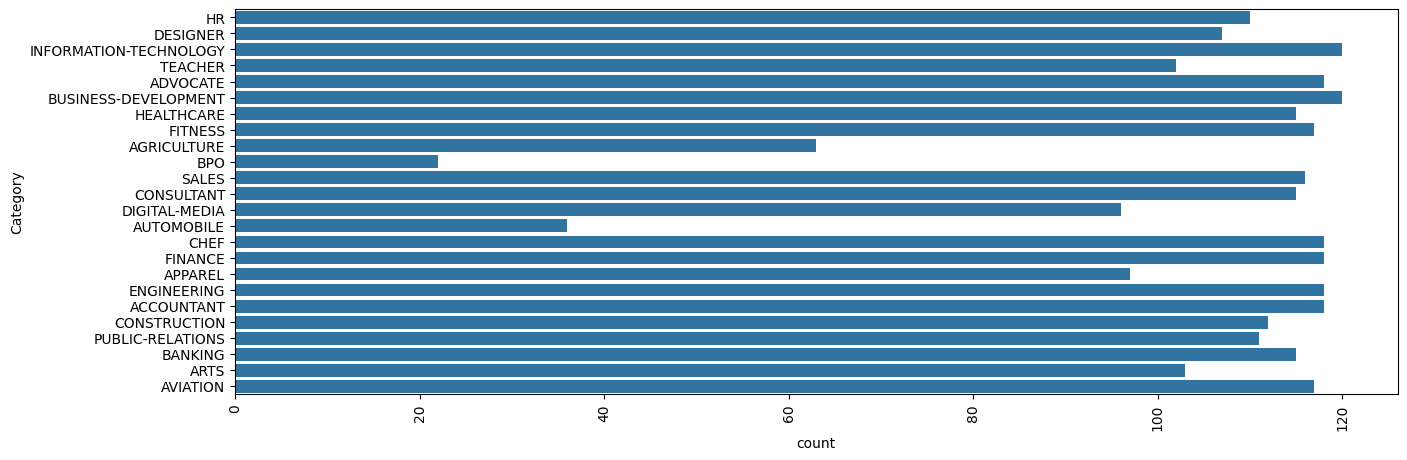

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot(clean_df['Category'])
plt.xticks(rotation=90)
plt.show()

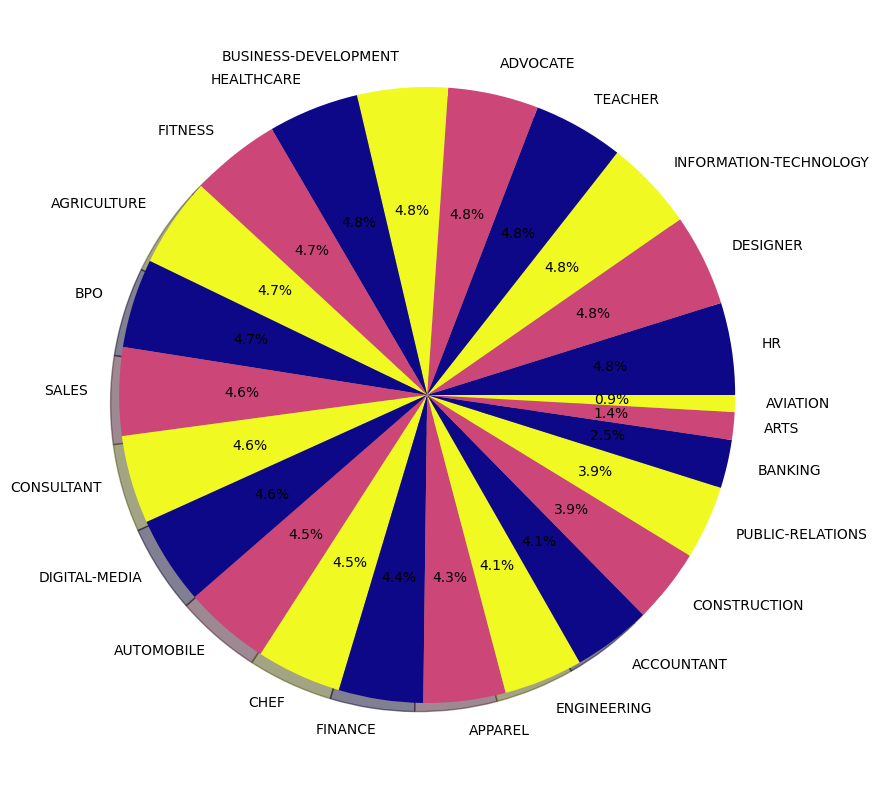

In [ ]:
counts = clean_df['Category'].value_counts()
labels = clean_df['Category'].unique()
plt.figure(figsize=(15,10))

plt.pie(counts,labels=labels,autopct='%1.1f%%',shadow=True, colors=plt.cm.plasma(np.linspace(0,1,3)))
plt.show()

In [ ]:
clean_df['Category'].unique()

array(['HR', 'DESIGNER', 'INFORMATION-TECHNOLOGY', 'TEACHER', 'ADVOCATE',
       'BUSINESS-DEVELOPMENT', 'HEALTHCARE', 'FITNESS', 'AGRICULTURE',
       'BPO', 'SALES', 'CONSULTANT', 'DIGITAL-MEDIA', 'AUTOMOBILE',
       'CHEF', 'FINANCE', 'APPAREL', 'ENGINEERING', 'ACCOUNTANT',
       'CONSTRUCTION', 'PUBLIC-RELATIONS', 'BANKING', 'ARTS', 'AVIATION'],
      dtype=object)

#Balance Dataset

In [ ]:
from sklearn.utils import resample

# Define the maximum count among all categories
max_count = clean_df['Category'].value_counts().max()

# Resample each category to match the maximum count
balanced_data = []
for category in clean_df['Category'].unique():
    category_data = clean_df[clean_df['Category'] == category]
    if len(category_data) < max_count:
        # Perform oversampling for categories with fewer samples
        balanced_category_data = resample(category_data, replace=True, n_samples=max_count, random_state=42)
    else:
        # Perform undersampling for categories with more samples
        balanced_category_data = resample(category_data, replace=False, n_samples=max_count, random_state=42)
    balanced_data.append(balanced_category_data)

# Concatenate the balanced data for all categories
balanced_df = pd.concat(balanced_data)

In [ ]:
balanced_df['Category'].value_counts()

,count
Category,
HR,120
DESIGNER,120
INFORMATION-TECHNOLOGY,120
TEACHER,120
ADVOCATE,120
BUSINESS-DEVELOPMENT,120
HEALTHCARE,120
FITNESS,120
AGRICULTURE,120


In [ ]:
# balanced_df.isnull().sum()
balanced_df.dropna(inplace=True)

#Train-Test Split

In [ ]:
X = balanced_df['Feature']
y = balanced_df['Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Encoding (TF-IDF)

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

X_test_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 179711 stored elements and shape (576, 29780)>

#Train Random Forest Classifier

In [ ]:
# Phần 1: Định nghĩa các mô hình và huấn luyện
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

print("Huấn luyện và so sánh các mô hình phân loại CV...")

# Encode categories to integers for XGBoost
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Mapping to convert predictions back to original categories
original_categories = label_encoder.classes_
label_mapping = {i: label for i, label in enumerate(original_categories)}

# Danh sách các mô hình để huấn luyện và so sánh
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0, random_state=42),
    "Naive Bayes": MultinomialNB(alpha=0.1),
    "SVM": SVC(kernel='linear', C=1.0, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
}

xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

accuracies = {}
best_predictions = {}

# Huấn luyện và đánh giá các mô hình truyền thống
for name, model in models.items():
    try:
        print(f"Training {name}...")
        model.fit(X_train_tfidf, y_train)  # Standard models use original labels
        preds = model.predict(X_test_tfidf)
        acc = accuracy_score(y_test, preds)
        accuracies[name] = acc
        best_predictions[name] = preds
        print(f"{name} Accuracy: {acc:.4f}")
    except Exception as e:
        print(f"Error with {name}: {str(e)}")

# Train XGBoost separately with encoded labels
try:
    print(f"Training XGBoost...")
    xgb_model.fit(X_train_tfidf, y_train_encoded)  # XGBoost uses encoded labels
    preds_encoded = xgb_model.predict(X_test_tfidf)

    # Convert predictions back to original category names
    preds = [label_mapping[pred] for pred in preds_encoded]

    acc = accuracy_score(y_test, preds)
    accuracies["XGBoost"] = acc
    best_predictions["XGBoost"] = preds
    print(f"XGBoost Accuracy: {acc:.4f}")
except Exception as e:
    print(f"Error with XGBoost: {str(e)}")

# Tìm mô hình có độ chính xác cao nhất
best_model_name = max(accuracies, key=accuracies.get)
if best_model_name == "XGBoost":
    best_model = {"type": "xgboost", "model": xgb_model, "label_encoder": label_encoder}
else:
    best_model = models[best_model_name]
best_accuracy = accuracies[best_model_name]
y_pred = best_predictions[best_model_name]

print(f"\nBest Model: {best_model_name} with Accuracy = {best_accuracy:.4f}")

Huấn luyện và so sánh các mô hình phân loại CV...
Training Logistic Regression...
Logistic Regression Accuracy: 0.7639
Training Naive Bayes...
Naive Bayes Accuracy: 0.7431
Training Random Forest...
Random Forest Accuracy: 0.8490
Training XGBoost...
XGBoost Accuracy: 0.9045

Best Model: XGBoost with Accuracy = 0.9045


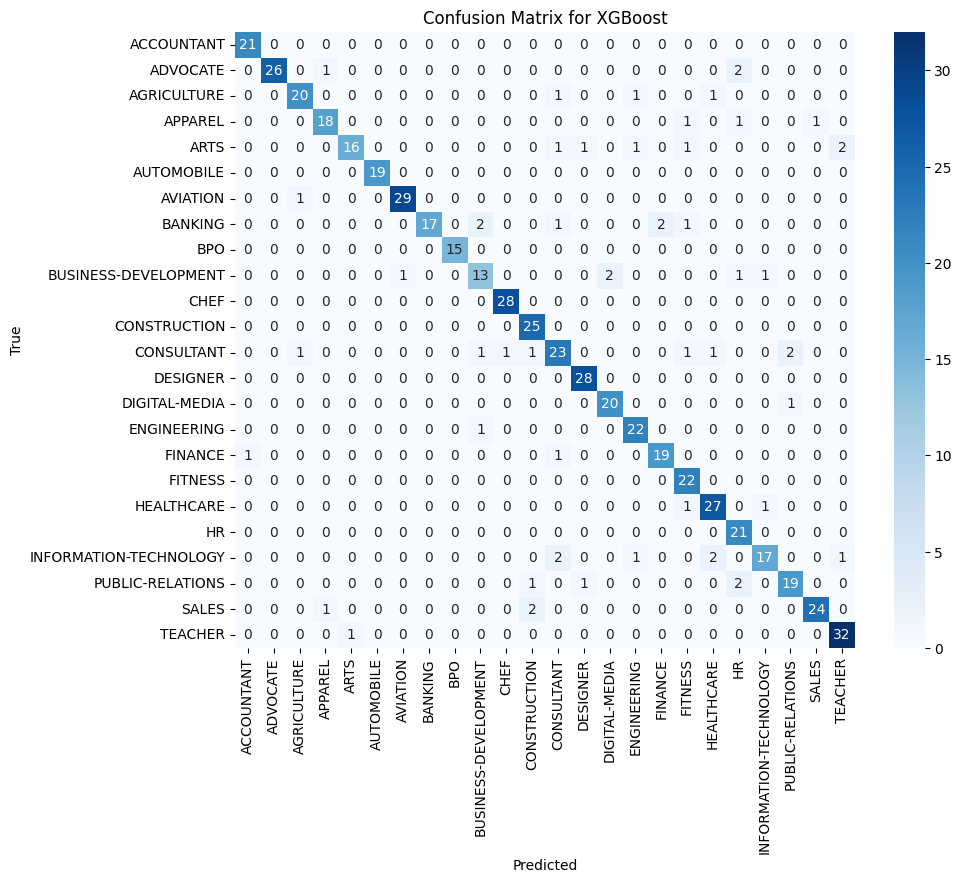

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_ if hasattr(best_model, 'classes_') else np.unique(y_test), yticklabels=best_model.classes_ if hasattr(best_model, 'classes_') else np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.show()

Logistic Regression: 0.7639
Naive Bayes: 0.7431
Random Forest: 0.8490
XGBoost: 0.9045
--------------------------------------------------
Best Model: XGBoost with Accuracy = 0.9045


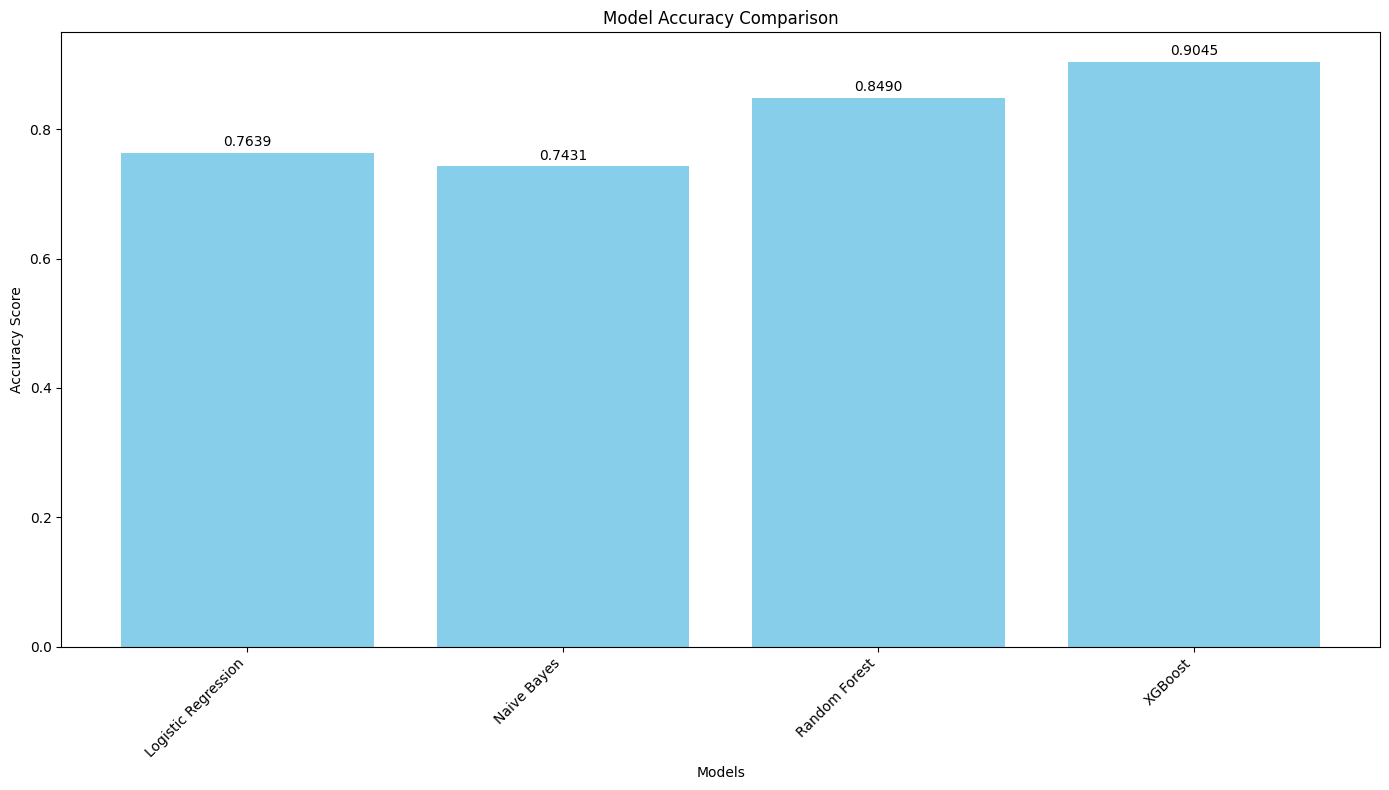

In [ ]:
# Phần 2: Hiển thị kết quả - Chỉ hiển thị accuracy, không hiển thị các cột khác
for name, acc in accuracies.items():
    print(f"{name}: {acc:.4f}")
print("-" * 50)
print(f"Best Model: {best_model_name} with Accuracy = {best_accuracy:.4f}")

# Visualize the accuracy comparison
plt.figure(figsize=(14, 8))
plt.bar(accuracies.keys(), accuracies.values(), color='skyblue')
plt.xlabel('Models')
plt.ylabel('Accuracy Score')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(accuracies.values()):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
plt.tight_layout()
plt.show()

#Predictive System

In [ ]:
# Clean resume
import re
def cleanResume(txt):
    cleanText = re.sub('http\S+\s', ' ', txt)
    cleanText = re.sub('RT|cc', ' ', cleanText)
    cleanText = re.sub('#\S+\s', ' ', cleanText)
    cleanText = re.sub('@\S+', '  ', cleanText)
    cleanText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', cleanText)
    cleanText = re.sub(r'[^\x00-\x7f]', ' ', cleanText)
    cleanText = re.sub('\s+', ' ', cleanText)
    return cleanText


# Prediction and Category Name
def predict_category(resume_text):
    resume_text = cleanResume(resume_text)
    resume_tfidf = tfidf_vectorizer.transform([resume_text])

    # Check if best_model is XGBoost (stored as dictionary)
    if isinstance(best_model, dict) and best_model.get("type") == "xgboost":
        # For XGBoost, we need to handle the label encoding
        xgb_model = best_model["model"]
        label_encoder = best_model["label_encoder"]

        # Get the encoded prediction
        encoded_pred = xgb_model.predict(resume_tfidf)[0]

        # Convert back to original category name
        predicted_category = label_encoder.inverse_transform([encoded_pred])[0]

    # Handle BERT model case for backward compatibility
    elif isinstance(best_model, dict) and best_model.get("type") == "bert":
        tokenizer = best_model["tokenizer"]
        model = best_model["model"]
        label_map = best_model["label_map"]
        inv_label_map = {i: label for label, i in label_map.items()}

        # Tokenize input text
        inputs = tokenizer(
            resume_text,
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors='pt'
        )

        # Move inputs to the right device
        device = model.device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Make prediction with BERT
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            predicted_class_idx = torch.argmax(logits, dim=1).item()

        # Convert index back to original label
        predicted_category = inv_label_map[predicted_class_idx]

    else:
        # Standard models (Logistic Regression, Naive Bayes, Random Forest)
        predicted_category = best_model.predict(resume_tfidf)[0]

    return predicted_category

In [ ]:
# Example Usage
resume_file = """hr assistant summary hard worker dedicated detailed oriented experienced organized highly motivated many attributes possess individual years experience human resource administration customer service talent quickly adapt new challenges experience focused benefits administration payroll career development employment law highlights assigned administrative assignments daily basis implemented employee handbook processed documentation employees conducted employees performance reviews managed employee scheduling coordinated upper level co worker lower level teamwork oriented processed new recruits processed payroll performed check managed inventory supplies secured new wholesale food purveyor decrease costs increase profits accomplishments accomplishments pho n restaurant managed restaurant financial objectives developing financing establishing banking relationships prepared strategic annual forecasts budgets analyzing variances initiating corrective actions establishing financial controls developed implemented strategies increase average meal checks created restaurant business plan surveying restaurant demand conferring people community identifying evaluating competitors preparing financial marketing sales projections analyses estimates controlled purchases inventory meeting account manager negotiating prices contracts developing preferred supplier lists reviewing evaluating usage reports analyzing variances taking corrective actions contributed team effort inspired team members motivation provided high level customer service maintain high profile day day operations handled complaints contentious issues settled directly team members provides fast solution accomplished campaign recycle program divide right trash right bin accomplishments dr norman g mckoy associates demonstrated success administrative employee handbook developing team building programs corporate policies job descriptions management reports organized office documents patients charts organized office woking areas welcomed new employees organization conducting orientation organized employees document pockets maintained employees confidence protect operation keeping human resource information confidential maintained employee information entering updating employment status change data provided payroll information collecting time attendance records provided secretarial support entering formatting printing information organizing work answering telephone relaying messages maintaining equipment supplies experience company name city state hr assistant increased productivity physician office organizing patients charts converting digital files streamline patient maintenance processed pay roll paychex includes ensured vacation sick time tracked system answered payroll questions facilited resolutions payroll errors processed incoming mails going mails successfully edited employee handbook define job descriptions create office policies patient managing proper patient reports wrote employee handbook covering issues including disciplinary procedures code conduct fmla policy benefits information wrote standard operations procedures manual sops detailed aspect employee expectations designed implement overall recruiting strategy coordinated office manager recruit right candidates administering interviews conducting background checks processed documentation prepared reports relating personnel activities staffing recruitment training performance evaluations etc identified reduced business expenses increase profits controlling budget compares actual results budget expectations company name city state general manager current hostess waitress promoted interview recruit new hires order sustain longer hours operation thus increased company profitswas successful ensuring successful integration new hires implementing training compensation structures ordered foods supplies restaurant checked maintained inventory handling daily accounting processing payroll processed cost reduction thought venders whole sale increased marketability restaurant designing creating new modernized menu prepared willing step restaurant short staff low turn order increase productivity provide best service maintained great quality quantity foods restaurant created recycle program divided recyclable bin non recyclable waste bin education bachelor arts humanities english university thai chamber commerce city thailand humanities english excelled language culture transportation management critical reading article writing advanced technical reading master science human resource management strayer university city state usa human resource management magna cum laude excelled human resources law management ethical hr information systems hris strategic management registered professional human resources aphr certification hr designations registering aphr professional human resources exam expect complete aphr certification professional affiliations enrolling ongoing training areas compensation benefits employee labor relations leaves absence workers compensation workplace safety security member society human resource management shrm skills human resource management skills employment law hr policies procedures training development performance management employee relations mediation benefits administration orientation boarding organizational development staff life cycle computer skills hris applications peoplesoft enterprise human resources ms office word excel powerpoint access outlook e mailing tools ms outlook windows outlook yahoo google networking skills job boards networking sites soft skills professional communication skills interpersonal skills bilingual thai english excellent adaptability new environments hard working flexible reliable honest polite shape decision making excellent customer service skills creative
"""

predicted_category = predict_category(resume_file)
print("Predicted Category:", predicted_category)

Predicted Category: HR


In [ ]:
# Example Usage
resume_file='information technology manager network engineer professional overview highly skilled accomplished information technology manager years expertise planning implementing streamlining systems ensure maximum customer satisfaction business revenue strong leader demonstrated ability work effectively individuals levels functional areas exceptional communication project management skills ability successfully manage multiple priorities assignments skills platforms windows server professional windows xp pro home win dos citrix ica ms exchange hardware hp ibm dell intel based server desktop platforms cisco switches sonic wall hardware vpns hp laser jets toshiba e color copier toshiba sony laptops inter tel software ms office visio citrix metaframe xp symantec pc anywhere ghost antivirus utilities win fax mcafee virus scan adobe acrobat illustrator photoshop partition magic adware spyware networking tcp ip wireless b g dns wins dhcp relevant experience information technology manager network engineer feb current company name city state responsible day day operations functions wilkes six offices staff members currently lead team professionals developers planning upgrades implementation systems business applications development new software tools work closely cio senior management ensure business technology objectives aligned researched new technologies calculated future needs achieve accurate capacity planning negotiated hardware software purchases maintenance contracts dramatically reduced costs maintenance virtualizing company infrastructure using vmware reduced physical servers streamlined disaster recovery processes planned executed active directory domain migration r coordinated planning migration mpls network sites including upgrades routers switches network equipment increased speed reliability company email migrating microsoft exchange streamlined operations designing new citrix infrastructure using netscaler load balancers ensure better speed connectivity less downtime remote offices led planning implementation disaster recovery site atlanta created company first comprehensive business continuity plan tested success installed configuring barracuda spam virus firewalls resulting reduction spam enforced security policies managed monitored updated spam filtering virus malware prevention systems reduced desktop application deployment times designing implementing microsoft system center configuration manager conducted training internal systems local procedures technical subjects company employees coordinate external technology vendors internal staff members third party consultants network engineer sep jan company name city state administered managed windows server network environment responsible lan wan duties local remote networks acted technical consultant clients various projects provide end user support windows xp operating systems installed implemented exchange mail server implemented server desktop security using mcafee enterprise epolicy orchestrator installed configured web servers ftp servers pop mail servers manage cisco switches routers configured vpn remote access users implemented software domain policies patches upgrades using group policy sus trained new employees systems administration web development network support technician jan aug company name city provided network desktop support users provided technical support offices b domain supported help desk using help star software troubleshooting windows desktop computers implemented group policy objects control desktop environment security performed hardware software upgrades replacements performed installations troubleshooting ms office suite managed users computers organizational units active directory created disc images desktop notebook computers using norton ghost troubleshooting repairs laser printers copy machines education bachelor science management information systems university maryland university college city state certifications microsoft certified technology specialist mcts citrix certified administrator cca information systems management certificate project management certificate'

predicted_category = predict_category(resume_file)
print("Predicted Category:", predicted_category)

Predicted Category: INFORMATION-TECHNOLOGY


In [ ]:
# Example Usage
resume_file = """Objective:
A creative and detail-oriented Designer with a passion for visual communication and brand identity seeking opportunities to leverage design skills in a dynamic and collaborative environment.

Education:
- Bachelor of Fine Arts in Graphic Design, XYZ College, GPA: 3.7/4.0
- Diploma in Web Design, ABC Institute, GPA: 3.9/4.0

Skills:
- Proficient in Adobe Creative Suite (Photoshop, Illustrator, InDesign)
- Strong understanding of typography, layout, and color theory
- Experience in both print and digital design
- Ability to conceptualize and execute design projects from concept to completion
- Excellent attention to detail and time management skills

Experience:
Graphic Designer | XYZ Design Studio
- Created visually appealing graphics for various marketing materials, including brochures, flyers, and social media posts
- Collaborated with clients to understand their design needs and deliver creative solutions that align with their brand identity
- Worked closely with the marketing team to ensure consistency in brand messaging across all platforms

Freelance Designer
- Designed logos, branding materials, and website layouts for small businesses and startups
- Managed multiple projects simultaneously while meeting tight deadlines and maintaining quality standards
- Established and maintained strong client relationships through clear communication and exceptional service

Projects:
- Rebranding Campaign for XYZ Company: Led a team to redesign the company's logo, website, and marketing collateral, resulting in a 30% increase in brand recognition
- Packaging Design for ABC Product Launch: Developed eye-catching packaging designs for a new product line, contributing to a successful launch and positive customer feedback

Certifications:
- Adobe Certified Expert (ACE) in Adobe Illustrator
- Responsive Web Design Certification from Udemy

Languages:
- English (Native)
- Spanish (Intermediate)
"""
predicted_category = predict_category(resume_file)
print("Predicted Category:", predicted_category)

Predicted Category: DESIGNER


In [ ]:
# Example Usage
resume_file = """Objective:
Dedicated and results-oriented Banking professional with a strong background in financial analysis and customer service seeking opportunities to contribute to a reputable financial institution. Eager to leverage expertise in risk management, investment strategies, and relationship building to drive business growth and client satisfaction.

Education:
- Bachelor of Business Administration in Finance, XYZ University, GPA: 3.8/4.0
- Certified Financial Analyst (CFA) Level I Candidate

Skills:
- Proficient in financial modeling and analysis using Excel, Bloomberg Terminal, and other financial software
- Extensive knowledge of banking products and services, including loans, mortgages, and investment products
- Strong understanding of regulatory compliance and risk management practices in the banking industry
- Excellent communication and interpersonal skills, with a focus on building rapport with clients and colleagues
- Ability to work efficiently under pressure and adapt to changing market conditions

Experience:
Financial Analyst | ABC Bank
- Conducted financial analysis and risk assessment for corporate clients, including credit analysis, financial statement analysis, and cash flow modeling
- Developed customized financial solutions to meet clients' needs and objectives, resulting in increased revenue and client retention
- Collaborated with cross-functional teams to identify new business opportunities and optimize existing processes

Customer Service Representative | DEF Bank
- Provided exceptional customer service to bank clients, addressing inquiries, resolving issues, and promoting banking products and services
- Processed transactions accurately and efficiently, including deposits, withdrawals, and account transfers
- Educated customers on various banking products and services, helping them make informed financial decisions

Internship | GHI Investments
- Assisted portfolio managers with investment research and analysis, including industry and company-specific research, financial modeling, and performance analysis
- Prepared investment presentations and reports for clients, highlighting investment opportunities and performance metrics
- Conducted market research and analysis to identify trends and opportunities in the financial markets

Certifications:
- Certified Financial Planner (CFP)
- Series 7 and Series 63 Securities Licenses

Languages:
- English (Native)
- Spanish (Proficient)

"""
predicted_category = predict_category(resume_file)
print("Predicted Category:", predicted_category)

Predicted Category: BANKING


#Save Files

In [ ]:
import pickle
# Save the best model and required components
if best_model_name == "XGBoost":
    # For XGBoost, we need to save both the model and the label encoder
    pickle.dump({"model": xgb_model, "label_encoder": label_encoder, "type": "xgboost"},
                open('/content/drive/MyDrive/HK4_N2/NLP/FinalProject/models/best_model_categorization.pkl','wb'))
else:
    # For standard models (Logistic Regression, Naive Bayes, Random Forest)
    pickle.dump(best_model, open('/content/drive/MyDrive/HK4_N2/NLP/FinalProject/models/best_model_categorization.pkl','wb'))

# Always save the vectorizer
pickle.dump(tfidf_vectorizer, open('/content/drive/MyDrive/HK4_N2/NLP/FinalProject/models/tfidf_vectorizer_categorization.pkl','wb'))

print(f"Saved {best_model_name} as the best model with accuracy: {best_accuracy:.4f}")

Saved XGBoost as the best model with accuracy: 0.9045
